In [1]:
import sys
sys.path.append('../')
sys.path.append("....")

In [2]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict



## Params:

In [3]:
aggregate_by_state = False
outcome_type = 'cases'

## Basic Data Visualization

In [4]:
# Just something to quickly summarize the number of cases and distributions each day

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


KeyError: '#Deaths_3/30/2020'

In [ ]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

In [ ]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [ ]:
sum(max_cases)

In [ ]:
print(sum([v > 50 for v in max_cases]))


In [ ]:
np.quantile(max_cases,.5)

Number of counties with non-zero deaths
2510


(array([1.402e+03, 5.300e+01, 2.400e+01, 1.400e+01, 1.500e+01, 7.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([6.0000e+00, 2.4880e+02, 4.9160e+02, 7.3440e+02, 9.7720e+02,
        1.2200e+03, 1.4628e+03, 1.7056e+03, 1.9484e+03, 2.1912e+03,
        2.4340e+03, 2.6768e+03, 2.9196e+03, 3.1624e+03, 3.4052e+03,
        3.6480e+03, 3.8908e+03, 4.1336e+03, 4.3764e+03, 4.6192e+03,
        4.8620e+03, 5.1048e+03, 5.3476e+03, 5.5904e+03, 5.8332e+03,
        6.0760e+03, 6.3188e+03, 6.5616e+03, 6.8044e+03, 7.0472e+03,
        7.2900e+03]),
 <a list of 30 Patch objects>)

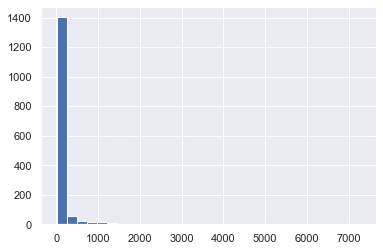

In [11]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

    
print('Number of counties with non-zero deaths')
print(sum([v > 0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [12]:
sum(max_deaths)

183947

In [13]:
max(max_deaths)

7290

In [14]:
np.quantile(max_deaths,.7)

16.699999999999818

### Clean data

In [15]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [16]:
method_keys = []

In [17]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [18]:
# target_day = np.array([1])
# # Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# # to a new column for test_df 
# # fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=np.array([1,2,3]))
# # fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# # Finds the names of all the methods
# method_keys = [c for c in df if 'predicted' in c]
# method_keys

In [19]:
# for days_ahead in [1, 2, 3]:
#      for method in ['exponential', 'shared_exponential', 'ensemble']:  
#         fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=np.array([days_ahead]))
        
#         if method == 'shared_exponential':
#             fit_and_predict(df,method='shared_exponential', 
#                             outcome=outcome_type, 
#                              mode='eval_mode',
#                              demographic_vars=very_important_vars,
#                              target_day=np.array([days_ahead]))
# method_keys = [c for c in df if 'predicted' in c]
# geo = ['countyFIPS', 'CountyNamew/StateAbbrev']

In [20]:
# method_keys = [c for c in df if 'predicted' in c]
# df_preds = df[method_keys + geo + ['deaths']]
# df_preds.to_pickle("multi_day_6.pkl")

## Ensemble predictions

In [22]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':'very_important_vars'}
linear = {'model_type':'linear'}

In [1]:
# import fit_and_predict
# for d in [1, 2, 3]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array([d]),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}'
#                                                    )

In [2]:
import fit_and_predict
for d in [1, 3, 5, 7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[exponential, 
                                                           shared_exponential,
                                                           demographics,
                                                           linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d}_with_exponential'
                                                   )

NameError: name 'df' is not defined

In [ ]:
method_keys = [c for c in df if 'predicted' in c]

In [70]:
# df = fit_and_predict.fit_and_predict_ensemble(df)

In [71]:
method_keys

[]

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [72]:
# TODO: add average rank as metric

In [73]:
# Computes the mse in log space and non-log space for all columns

In [74]:
def l1(arr1,arr2,norm=True):
    """
    arr2 ground truth
    arr1 predictions
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf

In [75]:

# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold)]] # * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

NameError: name 'df' is not defined

In [76]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

NameError: name 'df' is not defined

In [77]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

NameError: name 'df' is not defined

In [78]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

NameError: name 'df' is not defined

In [79]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds,norm=False))

NameError: name 'df' is not defined

### Plot residuals

In [80]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

In [81]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

In [82]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

NameError: name 'df' is not defined

In [83]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

NameError: name 'df' is not defined

In [84]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [10,400]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

NameError: name 'df' is not defined

### Graph Visualizations

In [85]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [86]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [87]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

In [88]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
        for v in very_important_vars:
            print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')

NameError: name 'df' is not defined